In [1]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime
from astral.sun import sun
from astral import Observer
from astral import LocationInfo
from astral.location import Location

In [2]:
from plot_functions import plot_data_distribution

In [3]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

## Load data

In [5]:
# Load data
file_path = os.path.join(current_directory, 'data/dataset_v2.csv')
df = pd.read_csv(file_path).rename(columns={"Unnamed: 0":"timestamp", "total_p_demand [kW]":"power_consumption"})
df

,timestamp,power_consumption,ghi,temp,wind
0,2022-01-01 00:00:00+00:00,NaN,0.00000,4.12000,1.10000
1,2022-01-01 01:00:00+00:00,NaN,0.00000,3.92000,1.31000
2,2022-01-01 02:00:00+00:00,NaN,0.00000,3.67000,1.24000
3,2022-01-01 03:00:00+00:00,NaN,0.00000,3.51000,1.17000
4,2022-01-01 04:00:00+00:00,NaN,0.00000,3.25000,1.17000
...,...,...,...,...,...
24859,2024-11-01 19:00:00+00:00,NaN,NaN,NaN,NaN
24860,2024-11-01 20:00:00+00:00,NaN,NaN,NaN,NaN
24861,2024-11-01 21:00:00+00:00,NaN,NaN,NaN,NaN
24862,2024-11-01 22:00:00+00:00,NaN,NaN,NaN,NaN


The dataset comprises time series of power consumption (the target variable) alongside ambient temperature, wind speed, and Global Horizontal Irradiance (GHI), which serve as exogenous variables. Power consumption is influenced by these exogenous factors: ambient temperature can drive heating or cooling demands, wind speed might correlate with ventilation or outdoor equipment usage, and GHI impacts natural lighting and, consequently, electricity demand for lighting or heating. 

## Data exploration

#### Data statistics and filtering of missing values

In [9]:
# Dataset statistics 
statistics = df.describe().transpose()
statistics['nans'] = df.isna().sum()  # Number of NaNs

statistics

,count,mean,std,min,25%,50%,75%,max,nans
power_consumption,18174.00000,7953.29239,1488.96223,4641.55953,6820.00000,7777.20835,8770.00000,15450.00000,6690
ghi,24840.00000,22.34319,436.87166,-999.00000,0.00000,0.00000,200.09750,984.01000,24
temp,24840.00000,8.46177,54.86241,-999.00000,5.19000,10.99000,17.46000,32.73000,24
wind,24840.00000,-1.54843,53.78482,-999.00000,0.89000,1.18000,1.66000,6.48000,24


`power_consumption` data is available only for a specific range of timestamps, therefore the dataset is filtered accordingly.
More specifically:
- Every timestamp before `2022-04-23 10:00` (index < 2458) is missing,
- Every timestamp after `2024-06-17 05:00` (idex > 21557) is missing.

In [11]:
# Filter the dataset
indexes_to_keep_logical = (df.index >= 2458) & (df.index<=21557)
indexes_to_drop_list = df[~indexes_to_keep_logical].index.tolist() # save indexes to drop

df = df.drop(index=indexes_to_drop_list).reset_index(drop=True)

# Dataset (filtered) statistics 
statistics = df.describe().transpose()
statistics['nans'] = df.isna().sum()  # Number of NaNs

statistics

,count,mean,std,min,25%,50%,75%,max,nans
power_consumption,18174.00000,7953.29239,1488.96223,4641.55953,6820.00000,7777.20835,8770.00000,15450.00000,926
ghi,19100.00000,162.38451,246.10739,0.00000,0.00000,2.00000,260.00250,984.01000,0
temp,19100.00000,11.69025,7.82706,-13.22000,5.51000,11.46000,17.88000,32.73000,0
wind,19100.00000,1.36697,0.72646,0.00000,0.90000,1.24000,1.72000,6.48000,0


#### Data distribution and filtering of outliers and non-physical data

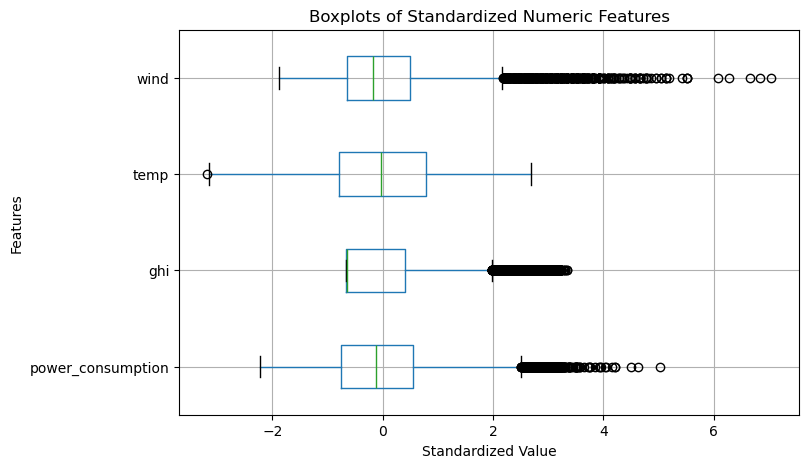

In [13]:
# Plot Boxplots for numeric columns - Boxplot

# 1. Standardized data
numeric_columns = df.select_dtypes(include='number').columns

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_standardized = pd.DataFrame(
    scaler.fit_transform(df[numeric_columns]),
    columns=numeric_columns,
    index=df.index
)
plt.figure(figsize=(8, 5))
df_standardized.boxplot(vert=False)
plt.title("Boxplots of Standardized Numeric Features")
plt.xlabel("Standardized Value")
plt.ylabel("Features")
plt.show()

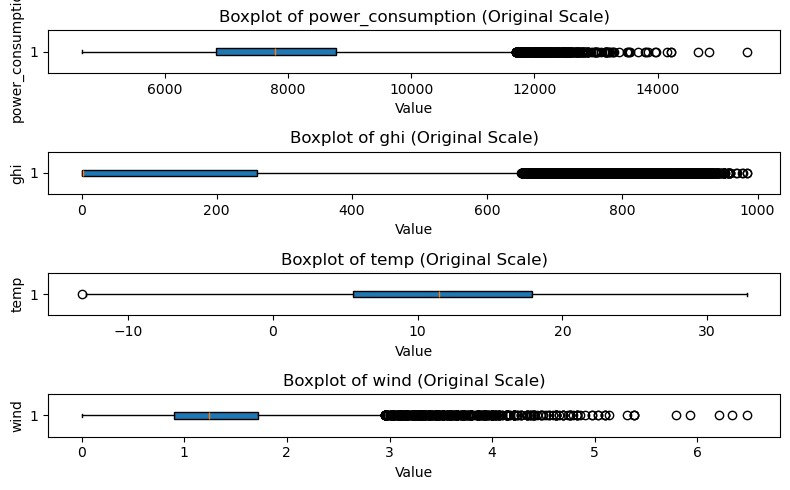

In [14]:
# 2. Original data (not standardized) - Boxplot
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=1, figsize=(8, 5), sharex=False)
    
for i, feature in enumerate(numeric_columns):
    ax = axes[i]
    ax.boxplot(df[feature].dropna(), vert=False, patch_artist=True)
    ax.set_title(f"Boxplot of {feature} (Original Scale)")
    ax.set_xlabel("Value")
    ax.set_ylabel(feature)

plt.tight_layout()
plt.draw()
plt.show()

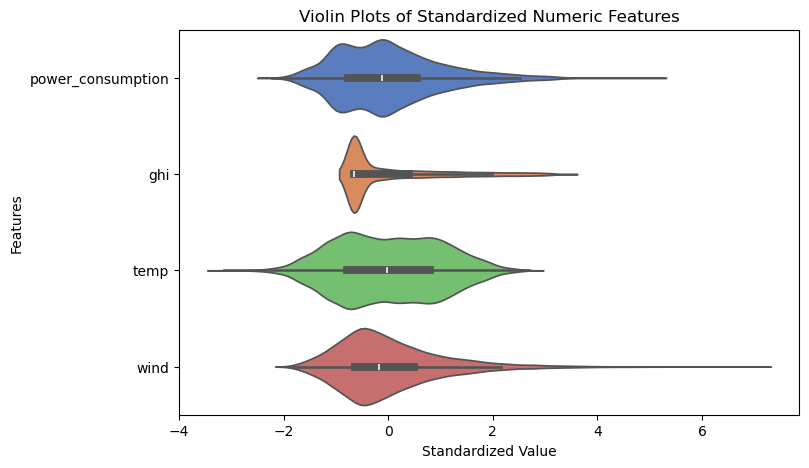

In [15]:
# 1. Standardized Data - Violin Plot 
plt.figure(figsize=(8, 5))
df_standardized_melted = df_standardized.melt(var_name="Feature", value_name="Standardized Value")
sns.violinplot(
    data=df_standardized_melted,
    x="Standardized Value",
    y="Feature",
    hue="Feature",  # Assign 'Feature' to hue
    palette="muted",
    density_norm="width",  # Replace deprecated 'scale' parameter
    legend=False  # Avoid duplicate legends
)
plt.title("Violin Plots of Standardized Numeric Features")
plt.xlabel("Standardized Value")
plt.ylabel("Features")
plt.show()

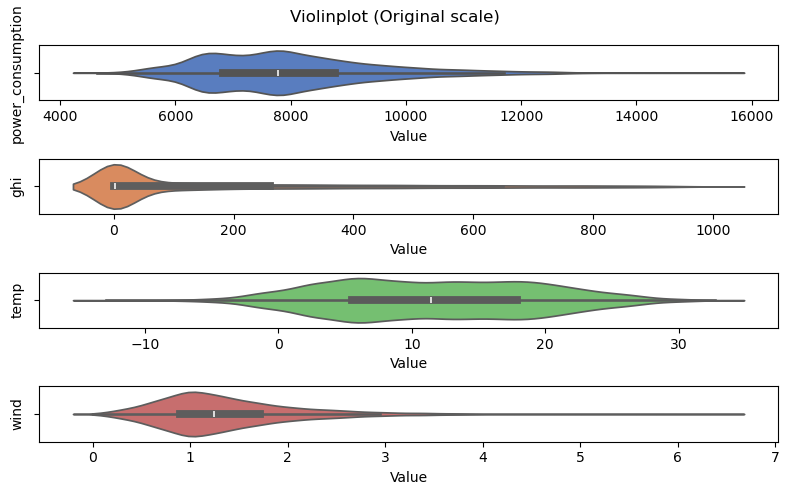

In [16]:
# 2. Original Data (not standardized) - Violin Plot 
colors = sns.color_palette("muted")
plot_data_distribution(df, numeric_columns, colors, 'Violinplot (Original scale)', False, 1)

The `wind`, `power_consumption`, and `ghi` features exhibit outliers in their tails. Appropriate techniques are implemented to address and manage these anomalies.

In [18]:
# Remove ghi data < 0
df.loc[df.loc[:,'ghi']<0,'ghi']=0

Negative GHI has no physical meaning.

#### Missing values imputation

Missing `power_consumption` values are imputed using the median value of the corresponding hour, over the entire dataset.

In [21]:
# Handle power_consumption missing values

# Convert the timestamps to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour

# Compute the median for each hour
hourly_median = df.groupby('hour')['power_consumption'].median()

# Fill missing values with the median of the corresponding hour
df['power_consumption'] = df.apply(
    lambda row: hourly_median[row['hour']] if pd.isna(row['power_consumption']) else row['power_consumption'],
    axis=1
)

##### Techniques for Handling Outliers

1. **Trimming**:
   - Outliers are replaced by the 1st and 99th percentile values.
   - Ensures that extreme values are clipped to a reasonable range without altering the overall structure of the data significantly.

2. **Local Outlier Factor (LOF)**:
   - Detects outliers using a density-based method.
   - Outliers are replaced with the nearest inlier values, ensuring continuity while removing abnormal points.

3. **Box-Cox Transformation**:
   - Applies a power transformation to make the data more Gaussian-like.
   - Useful for handling skewness and stabilizing variance but requires all values to be positive.

In [23]:
# Handle data outliers
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import pairwise_distances
from scipy.stats import boxcox

def handle_outliers(df, column):
    
    # -------- 1. Trimming ---------------------
    lower_limit = df[column].quantile(0.01)
    upper_limit = df[column].quantile(0.99)
    trimmed = np.clip(df[column], lower_limit, upper_limit)

    # -------- 2. Local outliers ---------------
    valid_data = df[[column]].dropna()  # Drop missing values
    lof = LocalOutlierFactor(n_neighbors=20)
    outlier = lof.fit_predict(valid_data)
    
    # Align predictions with original DataFrame
    df['outlier_flag'] = np.nan
    df.loc[valid_data.index, 'outlier_flag'] = outlier

    local_outliers_removed = df[column].copy()  # Create a copy to modify
    
    # Separate inliers and outliers
    inliers = df[df['outlier_flag'] == 1][column]
    outliers = df[df['outlier_flag'] == -1][column]
    
    # Replace outliers with the nearest inliers
    inlier_values = inliers.values.reshape(-1, 1)  # Reshape for distance calculations
    for idx, outlier_value in outliers.items():
        # Compute distances to all inliers
        distances = pairwise_distances([[outlier_value]], inlier_values)
        nearest_inlier_idx = np.argmin(distances)
        
        # Replace outlier with the nearest inlier's value
        local_outliers_removed.loc[idx] = inlier_values[nearest_inlier_idx][0]
    
    # -------- 3. Make data more normal-like --------
    if (df[column] <= -1).any():
        raise ValueError(f"Column {column} contains values <= -1, invalid for Box-Cox transformation.")
    boxcox_transformed, _ = boxcox(df[column] + 1)  # Add 1 to avoid log(0)

    # Drop temporary outlier flag column
    df.drop(columns=['outlier_flag'], inplace=True)

    return trimmed, local_outliers_removed, boxcox_transformed

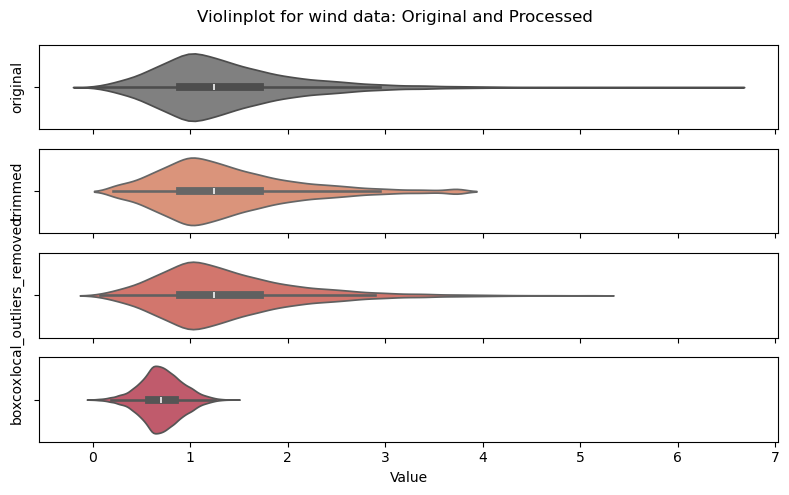

In [24]:
# Wind data
trimmed, local_outliers_removed, boxcox_transformed = handle_outliers(df, 'wind')

# Combine into a DataFrame
wind_outliers = pd.DataFrame({
    'original': df['wind'],
    'trimmed': trimmed,
    'local_outliers_removed': local_outliers_removed,
    'boxcox': boxcox_transformed
})

# Define colors for plotting
colors = ['grey']
colors.extend(sns.color_palette("flare"))

plot_data_distribution(
    wind_outliers,
    wind_outliers.columns,
    colors,
    'Violinplot for wind data: Original and Processed',
    True,
    1
)

# Update the cleaned dataset
df['wind'] = local_outliers_removed

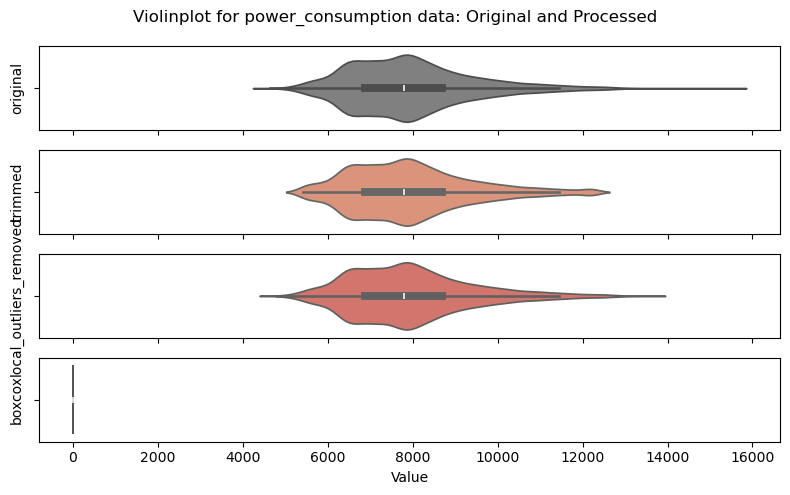

In [25]:
# Power consumption data
trimmed, local_outliers_removed, boxcox_transformed = handle_outliers(df, 'power_consumption')

# Combine into a DataFrame
power_consumption_outliers = pd.DataFrame({
    'original': df['power_consumption'],
    'trimmed': trimmed,
    'local_outliers_removed': local_outliers_removed,
    'boxcox': boxcox_transformed
})

# Define colors for plotting
colors = ['grey']
colors.extend(sns.color_palette("flare"))

plot_data_distribution(
    power_consumption_outliers,
    power_consumption_outliers.columns,
    colors,
    'Violinplot for power_consumption data: Original and Processed',
    True,
    1
)

# Update the cleaned dataset
df['power_consumption'] = local_outliers_removed

The technique implemented is Local Outlier Factor (LOF) for both `power_consumption` and `wind_data`. 

#### Cleaned dataset
The clean dataset statistics are reported below. 

In [28]:
# Dataset statistics 
statistics = df.describe().transpose()
statistics['nans'] = df.isna().sum()  # Number of NaNs

statistics

,count,mean,std,min,25%,50%,75%,max,nans
power_consumption,19100.00000,7942.17550,1455.49391,4795.64188,6866.18898,7788.35772,8700.00000,13540.00000,0
ghi,19100.00000,162.38451,246.10739,0.00000,0.00000,2.00000,260.00250,984.01000,0
temp,19100.00000,11.69025,7.82706,-13.22000,5.51000,11.46000,17.88000,32.73000,0
wind,19100.00000,1.36669,0.72452,0.07000,0.90000,1.24000,1.72000,5.14000,0
year,19100.00000,2022.88147,0.72618,2022.00000,2022.00000,2023.00000,2023.00000,2024.00000,0
month,19100.00000,6.39435,3.33926,1.00000,4.00000,6.00000,9.00000,12.00000,0
day,19100.00000,15.73550,8.78376,1.00000,8.00000,16.00000,23.00000,31.00000,0
hour,19100.00000,11.50084,6.92283,0.00000,5.00000,12.00000,18.00000,23.00000,0


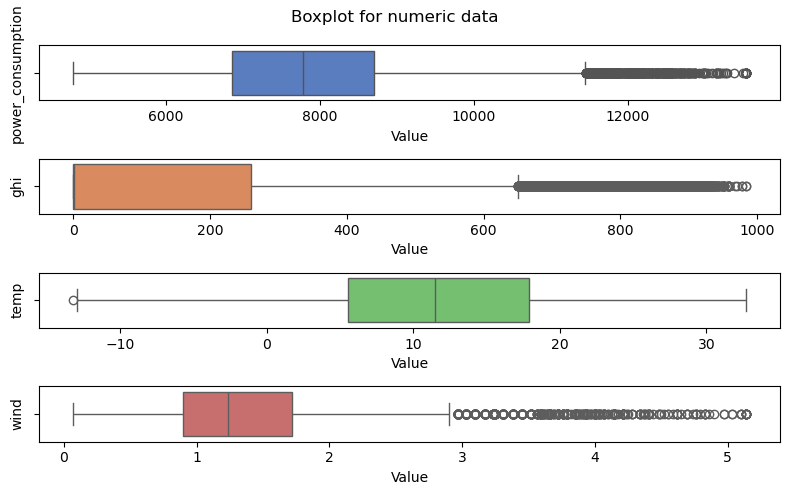

In [29]:
colors = sns.color_palette("muted")
plot_data_distribution(df, numeric_columns, colors, 'Boxplot for numeric data', False, 0)

## Feature engineering 

Feature engineering or data expansion enhances the predictive power of models by incorporating additional context and features that provide valuable insights into patterns and trends. For time series data, augmenting the dataset with variables such as **day of the week**, **holidays**, and **seasonal information** can capture recurring behaviors and external influences that affect the target variable. For example, power consumption may vary significantly between weekdays and weekends, during public holidays, or across different seasons. Including these features helps the model better understand and adapt to these variations, leading to more accurate and robust predictions.

In [31]:
# Day of the week
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

for i, day in enumerate(days):
    df[f'is_{day}'] = (df.timestamp.dt.dayofweek == i).astype(int)

In [32]:
# Weekend
df['is_weekend'] = df.timestamp.dt.dayofweek.isin([5, 6]).astype(int)  # 5 = Saturday, 6 = Sunday

In [33]:
# Season
seasons_mapping = {
    'spring': [3, 4, 5],  # March, April, May
    'summer': [6, 7, 8],  # June, July, August
    'autumn': [9, 10, 11],  # September, October, November
    'winter': [12, 1, 2]  # December, January, February
}

# Create a season indicator column for each season
for season, months in seasons_mapping.items():
    df[f'is_{season}'] = df.timestamp.dt.month.isin(months).astype(int)

In [34]:
# Holidays

# Define the holidays with tuples (start_date, end_date) 
# start_date: beginning of holiday period based on EPFL Academic Calendar
# end_date: end of holiday period based on EPFL Academic Calendar

holiday_periods = [
    ('2022-04-15', '2022-04-24'),
    ('2022-05-26', '2022-05-26'),
    ('2022-06-06', '2022-06-06'),
    ('2022-07-09', '2022-09-20'),
    
    ('2023-02-05', '2023-02-19'),
    ('2023-04-07', '2023-04-16'),
    ('2023-05-18', '2023-05-18'),
    ('2023-05-29', '2023-05-29'),
    ('2023-07-09', '2023-09-18'),
    
    ('2023-12-22', '2024-01-15'),
    ('2024-02-04', '2024-02-18'),
    ('2024-03-29', '2024-04-07'),
    ('2024-04-12', '2024-04-12'),
    ('2024-05-09', '2024-05-09'),
    ('2024-05-20', '2024-05-20'),
]

# Convert the start and end dates to datetime
holiday_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in holiday_periods]

def is_holiday(date):
    for start, end in holiday_periods:
        if start <= date <= end:
            return 1
    return 0

# Apply the function to create a binary 'vacation' column
df['is_holiday'] = df.timestamp.dt.tz_localize(None).apply(is_holiday)

In [35]:
# Sunlight
def is_sunlight(row):
    # Extract the date and full timestamp
    timestamp = row['timestamp']
    date = timestamp.date()

    # Define location information for Lausanne
    city = LocationInfo("Lausanne", "Switzerland", "Europe/Paris", 46.5212, 6.5653)

    # Calculate sunrise and sunset for the given date
    s = sun(city.observer, date=date, tzinfo=city.timezone)
    sunrise = s['sunrise'].replace(tzinfo=None) 
    sunset = s['sunset'].replace(tzinfo=None) 

    # Check if the timestamp is during the day
    return 1 if sunrise <= timestamp.replace(tzinfo=None)  <= sunset else 0

df['is_daylight'] = df.apply(is_sunlight, axis=1)

#### Clustering

Clustering involves grouping data into clusters based on similar patterns or behaviors using techniques such as k-means or hierarchical clustering. These cluster labels are then added as a new feature to the dataset, providing the model with additional insights into underlying structures or trends in the data.

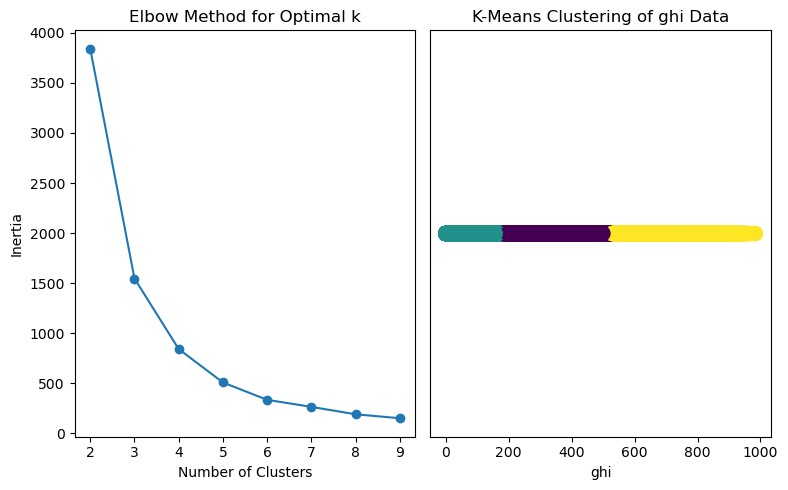

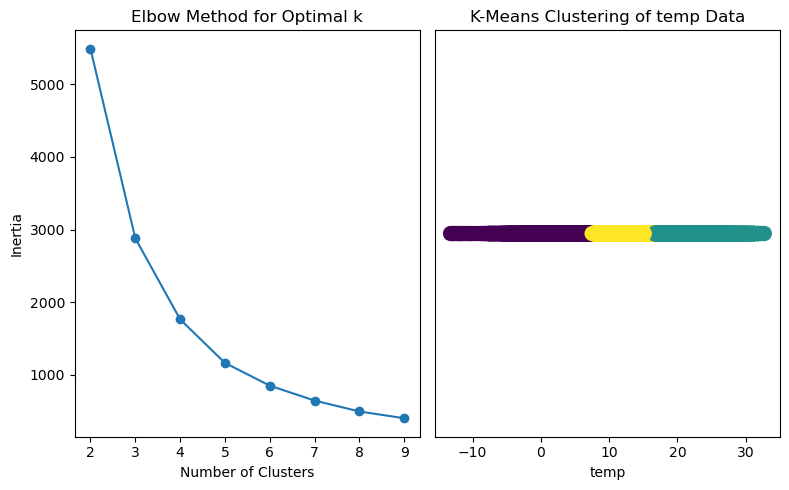

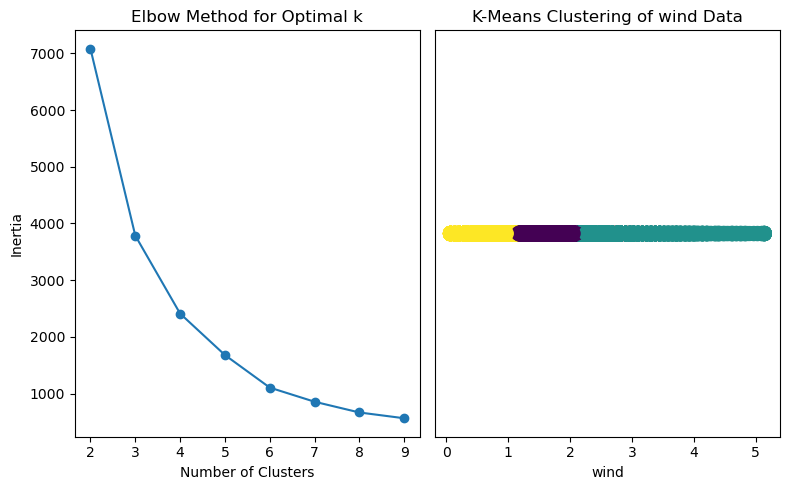

In [37]:
# Cluster with k-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_kmeans(df, columns):
    """
    Performs K-Means clustering on specified columns of the DataFrame
    and returns clusters in the original scale.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of columns to cluster.

    Returns:
        pd.DataFrame: DataFrame with cluster assignments in original scale.
    """
    augmented_df = df.copy()

    for column in columns:
        # Step 1: Normalize the data
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(augmented_df[[column]])
        
        # Step 2: Determine optimal number of clusters (Elbow Method)
        inertia = []
        for k in range(2, 10):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data_scaled)
            inertia.append(kmeans.inertia_)

        fig, axs = plt.subplots(1, 2, figsize=(8, 5))
        axs[0].plot(range(2, 10), inertia, marker='o')
        axs[0].set_title("Elbow Method for Optimal k")
        axs[0].set_xlabel("Number of Clusters")
        axs[0].set_ylabel("Inertia")
        
        # Step 3: Train K-Means with the optimal number of clusters (e.g., k=3)
        kmeans = KMeans(n_clusters=3, random_state=42)
        cluster_labels = kmeans.fit_predict(data_scaled)

        # Map cluster labels to cluster centers in the original scale
        cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
        cluster_map = {i: cluster_centers_original[i, 0] for i in range(len(cluster_centers_original))}

        # Assign clusters based on original scale
        augmented_df[column + '_clustered'] = [cluster_map[label] for label in cluster_labels]
        
        # Step 4: Visualize the clusters
        axs[1].scatter(
            augmented_df[column],
            [0] * len(augmented_df[column]),
            c=cluster_labels,
            cmap='viridis',
            s=100
        )
        axs[1].set_title(f"K-Means Clustering of {column} Data")
        axs[1].set_xlabel(column)
        axs[1].set_yticks([])

        plt.tight_layout()
        plt.show()

    return augmented_df

columns = ['ghi', 'temp', 'wind']
df = cluster_kmeans(df, columns)

#### Spectral analysis
Augmentation with spectral analysis involves extracting frequency-domain features from time series data using techniques like Fourier or wavelet transforms. These features capture periodic patterns or trends, which are then added as new variables to enrich the dataset and improve predictive performance.

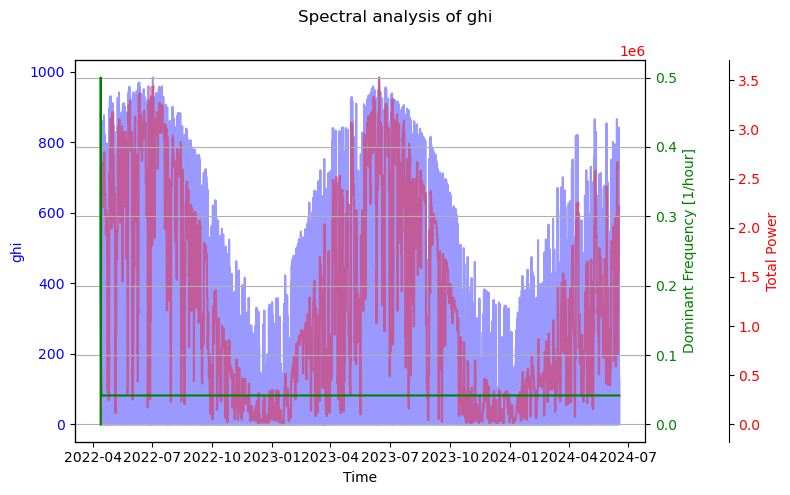

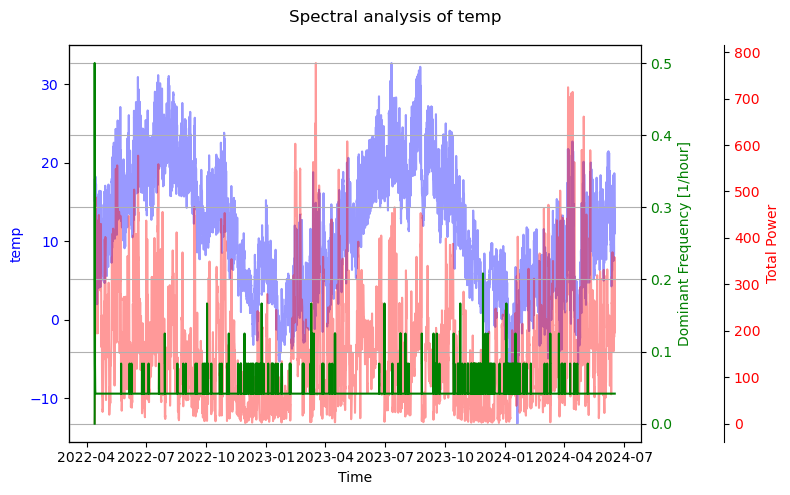

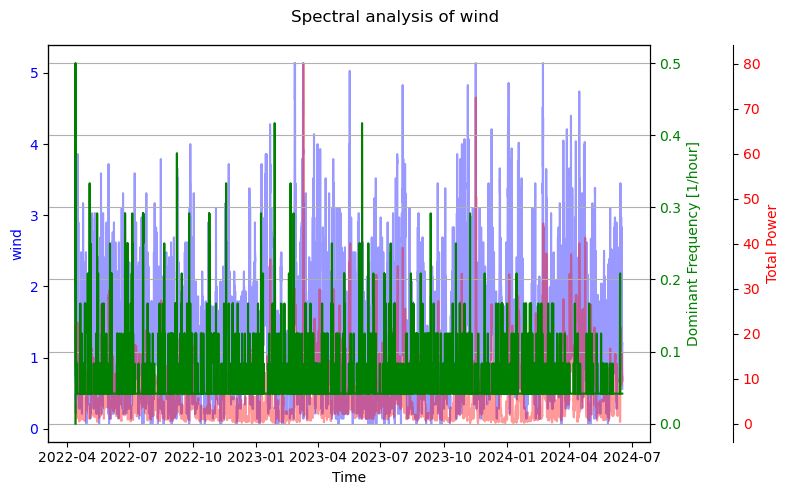

In [39]:
# Spectral analysis
from scipy.signal import periodogram

def spectral_analysis_over_window(df, columns):

    augmented_df = df.copy()
    
    # Rolling window for spectral features
    window_size = 24  # Example: 24-hour window
    for column in columns:
        dominant_frequencies = []
        total_powers = []
        for i in range(len(augmented_df)):
            # Define the rolling window
            if i < window_size:
                window_data = augmented_df[column][:i+1]
            else:
                window_data = augmented_df[column][i-window_size+1:i+1]
            
            # Perform spectral analysis
            frequencies, power_spectral_density = periodogram(window_data, fs=1)
            dominant_frequency = frequencies[np.argmax(power_spectral_density)]
            total_power = np.sum(power_spectral_density)
            
            # Append features
            dominant_frequencies.append(dominant_frequency)
            total_powers.append(total_power)
        augmented_df[column + '_dominant_frequencies'] = dominant_frequencies
        augmented_df[column + '_total_powers'] = total_powers
    return augmented_df

# plot function
def combined_plot(df, column):
    fig, ax1 = plt.subplots(figsize=(8, 5))
    
    # Plot GHI
    ax1.set_xlabel('Time')
    ax1.set_ylabel(column, color='blue')
    ax1.plot(df['timestamp'], df[column], label='GHI', color='blue', alpha=0.4)
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Add a third y-axis for total power
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
    ax2.set_ylabel('Total Power', color='red')
    ax2.plot(df['timestamp'], df[column + '_total_powers'], label='Total Power', color='red', alpha=0.4)
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add a second y-axis for dominant frequency
    ax3 = ax1.twinx()
    ax3.set_ylabel('Dominant Frequency [1/hour]', color='green')
    ax3.plot(df['timestamp'], df[column + '_dominant_frequencies'], label='Dominant Frequency', color='green', alpha=1)
    ax3.tick_params(axis='y', labelcolor='green')
    
    fig.suptitle('Spectral analysis of '+ column)
    fig.tight_layout() 
    plt.grid()
    
    plt.show()

columns = ['ghi', 'temp', 'wind']
df = spectral_analysis_over_window(df, columns)
for column in columns:
    combined_plot(df, column)

#### Temperature Feature Augmentation

- **Temperature Index:** Captures the absolute deviation of the temperature from a comfortable baseline (e.g., 22°C), quantifying discomfort due to temperature variations.  
- **Cumulative Degree Days (CDD):** Measures cumulative heat exposure when temperatures exceed the comfortable range, useful for identifying cooling needs.  
- **Heating Degree Days (HDD):** Optionally measures cumulative cold exposure when temperatures fall below the comfortable range, reflecting heating requirements.  

In [41]:
# Augment with temperature-specific derived features (linked to comfort limit)
def augment_temperature_features(df, temp_column, comfortable_temp=22):
    augmented_df = df.copy()
    
    # 1. Temperature Index (absolute deviation from comfortable temperature)
    augmented_df['Temperature_Index'] = abs(augmented_df[temp_column] - comfortable_temp)
    
    # 2. Cumulative Degree Days (CDD)
    # Cooling Degree Days: Temperature above comfortable range
    augmented_df['CDD'] = (augmented_df[temp_column] - comfortable_temp).clip(lower=0).cumsum()

    # Optional: Add Heating Degree Days (HDD) if needed
    # Heating Degree Days: Temperature below comfortable range
    augmented_df['HDD'] = (comfortable_temp - augmented_df[temp_column]).clip(lower=0).cumsum()
    
    return augmented_df

df = augment_temperature_features(df, temp_column='temp', comfortable_temp=22)

### Final Dataset  
Two versions of the dataset are prepared for testing with the models:  
1. The fully augmented dataset as described above.
2. A smaller version for preliminary analysis, to reduce computational burden, allowing for faster experimentation and model testing. This includes only the following features:  
   - `power_consumption`, `temp`, `hour`, `is_weekend`, `is_spring`, `is_summer`, `is_autumn`, `is_winter`, `is_holiday`, `is_daylight`.  

In [43]:
timestamps = df['timestamp']
X = df.drop(columns = 'timestamp')
columns_small = ['power_consumption', 'temp', 'hour', 'is_weekend', 'is_spring', 'is_summer', 'is_autumn', 'is_winter',
       'is_holiday', 'is_daylight']
X_small = X[columns_small]

Categorical variables are one-hot encoded such that they are represented in a numerical format suitable for machine learning models while avoiding the introduction of ordinal relationships that do not exist in the original data.

In [45]:
columns_to_dummy = ['hour']
X_small = pd.get_dummies(X_small, columns=columns_to_dummy, dtype=int, drop_first=True)
X_small

,power_consumption,temp,is_weekend,is_spring,is_summer,is_autumn,is_winter,is_holiday,is_daylight,hour_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,8260.00000,15.20000,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,7780.00000,16.13000,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,7700.00000,17.11000,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7890.00000,17.69000,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,8390.00000,17.95000,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19095,6393.30716,11.24000,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19096,6401.60043,10.98000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19097,6450.00000,11.09000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19098,6830.00000,12.11000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
columns_to_dummy = ['hour', 'month', 'ghi_clustered', 'temp_clustered', 'wind_clustered']
X = X.drop(columns = ['year', 'day'])
X = pd.get_dummies(X, columns=columns_to_dummy, dtype=int, drop_first=True)
X.columns.values

array(['power_consumption', 'ghi', 'temp', 'wind', 'is_monday',
       'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_sunday', 'is_weekend', 'is_spring', 'is_summer',
       'is_autumn', 'is_winter', 'is_holiday', 'is_daylight',
       'ghi_dominant_frequencies', 'ghi_total_powers',
       'temp_dominant_frequencies', 'temp_total_powers',
       'wind_dominant_frequencies', 'wind_total_powers',
       'Temperature_Index', 'CDD', 'HDD', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'ghi_clustered_336.8885817238397',
       'ghi_clustered_715.7946309314583',
       'temp_clustered_11.8933073813

In [47]:
# Save cleaned and augmented dataset
file_path = os.path.join(current_directory, 'data_expanded/timestamps.csv')
timestamps.to_csv(file_path)
file_path = os.path.join(current_directory, 'data_expanded/X_expanded.csv')
X.to_csv(file_path)
file_path = os.path.join(current_directory, 'data_expanded/X.csv')
X_small.to_csv(file_path)